In [1]:
# Import namespaces
import sys
import os
import math
import itertools
import json
import numpy as np
import scipy as scp
import matplotlib.pyplot as plt
import scipy.linalg as la
import pandapower as pp


from scipy.stats import norm
from scipy.stats import uniform
from scipy.stats import multinomial
from scipy.linalg import pinvh
from pandapower import networks

from tqdm.notebook import tqdm, trange
import time 

In [3]:
##### Setup Grid fluctuation parameters and constraints ########

## Std considered to be 1: 

cov_std = 1

### Number of samples used in experiments
### 500 is often enough
### 10000 is a default value supresses the variance

#nsmp = 10000; 
nsmp = 1000; 


### Step-sizes for KL and Var minimization 
### works well with 0.1-0.01

eta_vm = 0.1; 
eta_kl = 0.1; 

### Rounding threshold in optimization: 
### if a (normalized on the simplex) hpl probability becomes lower then 0.001
### we increase it to this level
###
### Crucially affects numerical stability
###

eps = 0.001

In [27]:
##### Setup regular polytope ########
### number of planes and distance
J = 360
tau = 3


### Matrix 
x_An = []
### Matrix rows
for i in range(J):
    x_An.append([math.sin(2 * math.pi * i / (J - 1)), math.cos(2 * math.pi * i / (J - 1))])
x_An = np.array(x_An)
### Distances
x_bn = np.ones(J) * tau
n = x_An.shape[1]

In [28]:
### Compute probabilities:
### prb: probability of each hpl failure 
### p_up, p_dwn: upper and lower bounds
###

prb = norm.cdf(-x_bn);
p_up = np.sum(prb);
p_dwn = np.max(prb);

print("the union bound (upper):", p_up)
print("the max bound (lower):", p_dwn)

the union bound (upper): 0.4859632913868336
the max bound (lower): 0.0013498980316300933


In [67]:
############# Monte-Carlo ##################

rv = norm(); 
x_std = norm.rvs(size=[n,nsmp])
smp = x_An@x_std

### fls_mc = failures in Monte-Carlo, e.g. 
### when MC discovers a failure
###

### probability estimates history
mc_exp_history = []
mc_std_history = []

fls_mc = sum((x_bn <= smp.T[:]).T); 
print("Max # of hlps a sample if out of: ", np.max(fls_mc))

### MC failure expectation and std
###

for i in range(nsmp):
    mc_exp_history.append((1 - np.sum(fls_mc[:i] == 0)/(i + 1)))
    mc_std_history.append(np.std(mc_exp_history))

mc_exp = (1 - np.sum(fls_mc == 0)/nsmp);
mc_std = mc_std_history[-1];
# violation_dict = {}
# for i in range(0,np.max(fls_mc)+1):
#     print(i, "hpls violated (exactly) vs # cases",  np.sum(fls_mc == i))
#     violation_dict[i] = int(np.sum(fls_mc == i))

print("\nMC(exp, std):", (mc_exp, mc_std)); 

### write into file
# path_to_viol_dirs = os.path.join("results", "hplns_violations")
# with open(os.path.join(path_to_viol_dirs, "grid3120", "result.json"), 'w+') as fp:
#     json.dump(violation_dict, fp)

Max # of hlps a sample if out of:  89

MC(exp, std): (0.019000000000000017, 0.038229450408979605)


In [45]:
############# ALOE ##################
### 
### Exactly follows to the Owen/Maximov/Chertkov paper, EJOS'19
###
### sample z ~ N(0, I_n)
### sample u ~ U(0,1)
### compute y = F^{-1}(u F(-b_i))
### compute x = - (a_i * y + (I - a_i.T * a_i) z)
###
### Ouput: union bound divided by the expected failure multiplicity
###


### Initialize samplers
###
### sample z ~ N(0, I_n) and u ~ U(0,1)
### 

rv = norm();
rv_u = uniform();
z = norm.rvs(size=[nsmp,n]); 
u = uniform.rvs(size=[nsmp]);


### x_alph is a vector of ALOE probabilities 
### normalized by a unit simplex
###

x_alph = prb/np.sum(prb);
#print("ALOE prbs for major hpls: ", x_alph)

### _hpl: how many smpls beyond each of the hpls
###

_hpl = multinomial.rvs(n = nsmp, p = x_alph);

### print("# samples per hpl", _hpl)

### Get cummulative sums, which are easier to work with
_hpl = list(itertools.accumulate(_hpl))
_hpl = np.array(_hpl)

### print("cusum of # hpls", _hpl)

### Generate samples
### x_aloe -- samples generated by ALOE
###
### TODO: seems optimizable, but I am not sure about memory mgmnt in python
x_aloe = np.zeros([nsmp, n]); 

# index of the active hyperplane
hpl_id = 0;

### get samples x_aloe according to the algorithm
#for i in tqdm(range(0,nsmp)):
for i in range(0,nsmp):
    ### get index of a hyperplane to sample beyond
    hpl_id = (hpl_id, hpl_id+1)[i >= _hpl[hpl_id]];
    y = norm.ppf(u[i]*norm.cdf(-x_bn[hpl_id]));
    x_aloe[i] = - x_An[hpl_id]*y - z[i] + np.outer(x_An[hpl_id],x_An[hpl_id])@z[i];

### test how many constraints are violated
smp = x_An@x_aloe.T

### compute expectation and std final and history
aloe_exp = p_up*np.sum(1./np.sum(x_bn <= smp.T[:],axis=1))/nsmp; 
aloe_std = p_up*math.sqrt(2*len(_hpl))/math.sqrt(nsmp); # indeed len(_hpl) instead of 2*m in the Thrm
aloe_exp_history = [p_up * np.sum(1. / np.sum(x_bn <= (x_An@x_aloe[:i, :].T).T, axis=1)) / (i + 1) for i in range(0,nsmp)]
aloe_std_history = [p_up*math.sqrt(2*len(_hpl))/math.sqrt(i + 1) for i in range(0, nsmp)]


print("ALOE (exp, std)", (aloe_exp, aloe_std))

ALOE prbs for major hpls:  [0.00277778 0.00277778 0.00277778 0.00277778 0.00277778 0.00277778
 0.00277778 0.00277778 0.00277778 0.00277778 0.00277778 0.00277778
 0.00277778 0.00277778 0.00277778 0.00277778 0.00277778 0.00277778
 0.00277778 0.00277778 0.00277778 0.00277778 0.00277778 0.00277778
 0.00277778 0.00277778 0.00277778 0.00277778 0.00277778 0.00277778
 0.00277778 0.00277778 0.00277778 0.00277778 0.00277778 0.00277778
 0.00277778 0.00277778 0.00277778 0.00277778 0.00277778 0.00277778
 0.00277778 0.00277778 0.00277778 0.00277778 0.00277778 0.00277778
 0.00277778 0.00277778 0.00277778 0.00277778 0.00277778 0.00277778
 0.00277778 0.00277778 0.00277778 0.00277778 0.00277778 0.00277778
 0.00277778 0.00277778 0.00277778 0.00277778 0.00277778 0.00277778
 0.00277778 0.00277778 0.00277778 0.00277778 0.00277778 0.00277778
 0.00277778 0.00277778 0.00277778 0.00277778 0.00277778 0.00277778
 0.00277778 0.00277778 0.00277778 0.00277778 0.00277778 0.00277778
 0.00277778 0.00277778 0.00277778 0

c:\users\aleks\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:58: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


ALOE (exp, std) (0.011023398129255471, 0.41235352649683704)


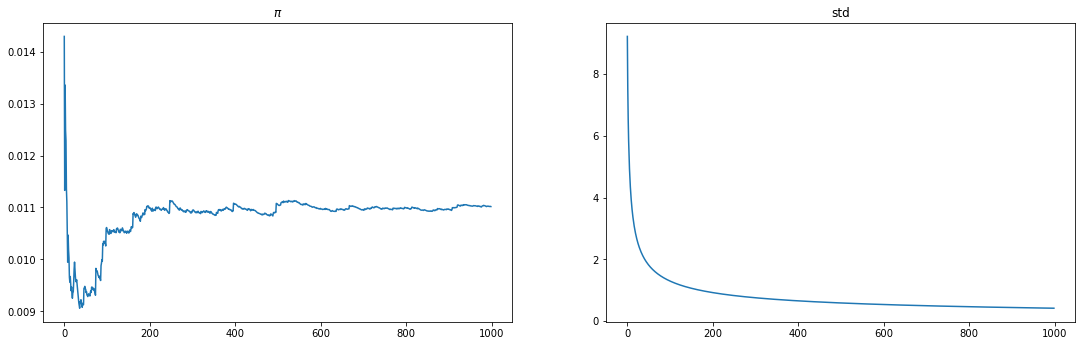

In [46]:

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18.5, 5.5)
ax1.set_title(r'$\pi$')
ax1.plot(aloe_exp_history[1:])
ax2.set_title('std')
ax2.plot(aloe_std_history[1:])


In [50]:
####### Optimization approach ######
#######
####### Variance Minimization ######
####### 


### setup the initial values

eta = eta_vm; 
md_var = 0; 
md_exp = 0;
grad = np.zeros(len(x_bn)); #gradient on each iteration
_hpl = np.zeros(nsmp); # hpls choosen by the method 

### intentionally use a copy instead of a reference
### alph is a vector of weigths to be updated in algorithm
###

alph = x_alph[:];

### history of probability estimate and std
md_exp_history = []
md_std_history = []

# values for Phi (x_bn)
x_phi = [norm.cdf(-x_bn[i]) for i in range(0, len(x_bn))]

### grad normalization by prbs[i] factor is introduced to make computations numerically stable
###

prbs = prb;

for i in tqdm(range(0,nsmp)):
    
    ### sample x according to current alph
    hpl_id = np.where(multinomial.rvs(n=1,p = alph, size=1, random_state=None)[0] == 1)[0];
    _hpl[i] = hpl_id;        
    
    ### generate a sample following to the ALOE procedure
    y = norm.ppf(u[i]*norm.cdf(-x_bn[hpl_id]));
    
    x_smp = - x_An[hpl_id]*y - z[i] + np.outer(x_An[hpl_id],x_An[hpl_id])@z[i];
    
    ### the RHS' to be compared with x_bn
    x_smp = x_An@x_smp.T;

    ### results of constraints violations for each generated object
    cns_vlt = (x_bn <= x_smp.T[:])[0]
    
    ### weight vector defined by the multiplicity of constraint violation for each sample
    wgt = 1./np.sum(np.multiply(cns_vlt, np.multiply(alph, 1./x_alph))); 
    
    
    ### compute gradient of the variance, see the paper (our + OMC) for details
    grad = [-p_up*p_up*wgt*wgt*norm.pdf(x_smp[k])[0]*cns_vlt[k]/prbs[k] for k in range(len(x_smp))];
    grad = np.array(grad)

    
    ### The gradient is high -- signal about emergency as it can zero out all weights
    if (la.norm(eta*grad)>1e4):
        print("\n##############    Extremely high gradient      ############\n");
        print("Iteration: ", i, "\nGradient:", grad)
    
    ### make a ``simplex MD'' update
    alph = [math.exp(-eta*grad[k])*alph[k] for k in range(0,len(x_smp))];
    

    ### enter if some coordinates are too small and may cause numerical instability
    ### increase the corresponding weigths
    if (np.min(alph) < eps):
        print("###########  some coordinates are small  #################")
        alph = [alph[k]+eps for k in range(0,len(x_bn))];
        
    ### make a projection to the unit simplex
    alph = alph/np.sum(alph); 
    
    ### adjust contribution to the errors
    md_exp = md_exp + wgt;
    md_exp_history.append(p_up * md_exp / (i + 1))
    md_var = md_var + p_up*np.dot(grad.T,grad);
    md_std_history.append(p_up * math.sqrt(md_var) / (i + 1))
    
    
print("Optimal weigths of MD-Var minimization: ", alph)
print("Optimal weigths of ALOE", x_alph)

### normalize errors, compute standard deviation
md_exp = p_up*md_exp/nsmp; 
md_std = p_up*math.sqrt(md_var)/nsmp;

print("MD-Var (exp, std)", (md_exp, md_std))
#print("assert normalization:", np.sum(alph), np.sum(x_alph))

  0%|          | 0/1000 [00:00<?, ?it/s]

Optimal weigths of MD-Var minimization:  [0.0027754  0.00277601 0.00277726 0.00277717 0.00277732 0.00277712
 0.00277742 0.0027768  0.00277746 0.00277718 0.00277693 0.00277681
 0.00277623 0.00277617 0.00277637 0.00277843 0.00277898 0.00277896
 0.00277897 0.0027784  0.00277774 0.00277783 0.00277795 0.00277795
 0.00277787 0.00277633 0.00277798 0.00277828 0.00277814 0.00277828
 0.00277798 0.00277777 0.0027778  0.00277719 0.00277775 0.00277772
 0.00277853 0.00277855 0.00277838 0.00277836 0.00277733 0.00277727
 0.00277759 0.00277742 0.0027776  0.00278038 0.00278043 0.00278041
 0.00278041 0.00278054 0.00277939 0.00277891 0.00277762 0.00277708
 0.00277456 0.00277457 0.00277446 0.00277484 0.00277477 0.00277529
 0.00277686 0.00277669 0.002777   0.00277676 0.0027787  0.00277917
 0.00277962 0.00277951 0.00277923 0.00277948 0.00278045 0.00278038
 0.00278051 0.00277919 0.00277889 0.00277765 0.00277764 0.00277757
 0.00277747 0.00277763 0.00277836 0.00277794 0.00277792 0.00277833
 0.00277832 0.0027785

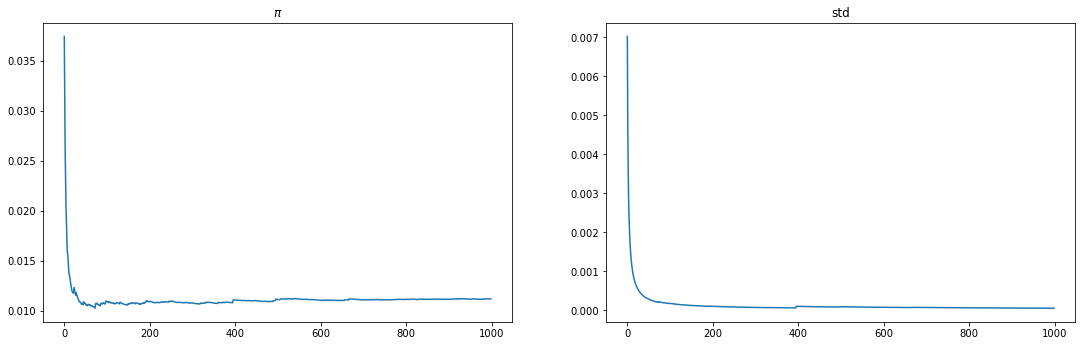

In [51]:

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18.5, 5.5)
ax1.set_title(r'$\pi$')
ax1.plot(md_exp_history[1:])
ax2.set_title('std')
ax2.plot(md_std_history[1:])


In [52]:
####### Optimization approach ######
#######
####### KL Minimization ######
#######

### SMD step-size
eta = eta_kl; 

### setup initial values
kl_exp = 0; 
kl_var = 0; 
grad = np.zeros(len(x_bn));
_hpl = np.zeros(nsmp); ## _hpl[i] = beyond which hpl we sample on iteration i

### intentionally use a copy instead of a reference
### alph is an optimization variable
alph = x_alph[:];

### history of probability estimate and std
kl_exp_history = []
kl_std_history = []

### this normalization factor is introduced to make computations numerically stable
prbs = prb;


for i in tqdm(range(0,nsmp)):#,miniters=500):
    
    ### sample x according to current alph
    hpl_id = np.where(multinomial.rvs(n=1,p = alph, size=1, random_state=None)[0] == 1)[0];
    _hpl[i] = hpl_id;        
    
    ### generate a sample accordint to ALOE
    y = norm.ppf(u[i]*norm.cdf(-x_bn[hpl_id]));
    x_smp = - x_An[hpl_id]*y - z[i] + np.outer(x_An[hpl_id],x_An[hpl_id])@z[i];
    
    ### RHS to compare with x_bn
    x_smp = x_An@x_smp.T;
    
    ### results of constraints violations for the generated object
    cns_vlt = (x_bn <= x_smp.T[:])[0]
    
    ### object weight which is set according to ALOE
    wgt = 1./np.sum(np.multiply(cns_vlt, np.multiply(alph, 1./x_alph))); 
    
    # the KL divergence's gradient 
    grad = [-p_up*wgt*norm.pdf(x_smp[k])[0]*cns_vlt[k]/prbs[k] for k in range(len(x_smp))];
    grad = np.array(grad)

    ### The gradient is high -- signal about emergency as it can zero out all weights
    if (la.norm(eta*grad)>1e4):
        print("\n##############    Extremely high gradient      ############\n");
        print("Iteration: ", i, "\nGradient:", grad)
    
    ### make a ``simplex MD'' update
    alph = [math.exp(-eta*grad[k])*alph[k] for k in range(0,len(x_smp))];
    
    ### enter if some coordinates are too small and may cause numerical instability
    ### increase the corresponding weigths
    if (np.min(alph) < eps):
        print("###########  some coordinates are small  #################")
        alph = [alph[k]+eps for k in range(0,len(x_bn))];
        
    ### make a projection to the unit simplex
    alph = alph/np.sum(alph); 
    
    ### adjust contribution to the errors
    kl_exp = kl_exp + wgt;
    kl_exp_history.append(p_up * kl_exp / (i + 1))
    kl_var = kl_var + p_up*np.dot(grad.T,grad)*wgt;
    kl_std_history.append(p_up * math.sqrt(kl_var) / (i + 1))
    
print("Optimal weigths of MD-KL minimization: ", alph)
print("Optimal weigths of ALOE", x_alph)

### normalize errors
kl_exp = p_up*kl_exp/nsmp; 
kl_std = p_up*math.sqrt(kl_var)/nsmp;
print("MD-KL (exp, std)", (kl_exp, kl_std))

#print("assert normalization:", np.sum(alph), np.sum(x_alph))

  0%|          | 0/1000 [00:00<?, ?it/s]

Optimal weigths of MD-KL minimization:  [0.00269795 0.0026924  0.00276144 0.00276031 0.00274933 0.00271339
 0.00274183 0.00273823 0.0027406  0.00274474 0.00276266 0.00274201
 0.00272527 0.00272573 0.0027882  0.00280418 0.00282857 0.00279118
 0.00278517 0.00278039 0.00282035 0.00279589 0.00280937 0.00282388
 0.00282044 0.00282232 0.00287354 0.00287143 0.00282176 0.00276173
 0.00280204 0.00276901 0.00277885 0.00277351 0.00276144 0.00277231
 0.002716   0.00268907 0.0026821  0.00269208 0.00270878 0.00272503
 0.00269625 0.00271111 0.00271259 0.00268942 0.00268558 0.00266447
 0.00266591 0.00266627 0.00269421 0.00271161 0.0027203  0.0027627
 0.00274816 0.00273638 0.00276925 0.00278571 0.00276748 0.00277367
 0.00278227 0.00278663 0.00281058 0.00280807 0.00280889 0.00278979
 0.0028191  0.00281948 0.00283338 0.00286947 0.00286575 0.00295879
 0.00294142 0.00294252 0.00291638 0.00292831 0.00293591 0.00291805
 0.00292241 0.00294548 0.00292558 0.00292143 0.00295009 0.0029479
 0.00294062 0.00296337 0

NameError: name 'prb_rmd' is not defined

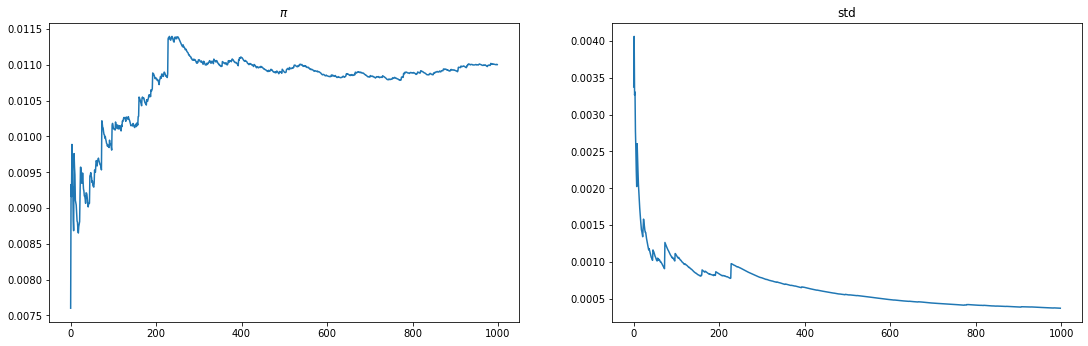

In [53]:

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18.5, 5.5)
ax1.set_title(r'$\pi$')
ax1.plot(kl_exp_history[1:])
ax2.set_title('std')
ax2.plot(kl_std_history[1:])


In [87]:
##############  Output all probabilities  ##################

print("the union bound (up):", p_up)
print("the max bound (lower):", p_dwn)

print("MC(exp, std):", mc_exp, mc_std); 
print("ALOE(exp, std)", aloe_exp, aloe_std)

print("MD-Var(exp, var)", md_exp, md_std)
print("MD-KL(exp, var)", kl_exp, kl_std)

the union bound (up): 0.035810970442567994
the max bound (lower): 0.02745583715517972
MC(exp, std): 0.04206303076613747 0.03162069600895248
ALOE(exp, std) 0.03409218453465473 0.0035810970442567997
MD-Var(exp, var) 0.03409834060531141 3.9318689405308525e-07
MD-KL(exp, var) 0.03358434341789244 2.0835946563090184e-05


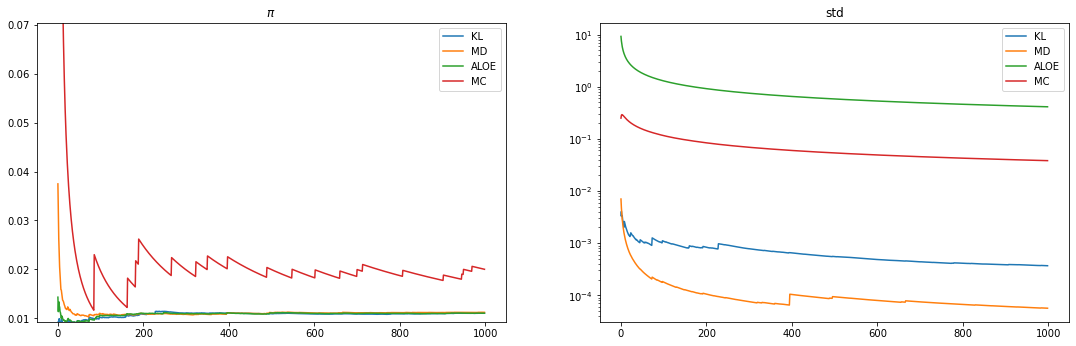

In [69]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18.5, 5.5)
ax1.set_title(r'$\pi$')
ax1.plot(kl_exp_history[1:], label='KL')
ax1.plot(md_exp_history[1:], label='MD')
ax1.plot(aloe_exp_history[1:], label='ALOE')
ax1.plot(mc_exp_history[1:], label='MC')
ax1.set_ylim(min(md_exp_history) - 1e-3, max(md_exp_history) + 1e-3)
ax1.legend()
ax2.set_title('std')
ax2.semilogy(kl_std_history[1:], label='KL')
ax2.semilogy(md_std_history[1:], label='MD')
ax2.semilogy(aloe_std_history[1:], label='ALOE')
ax2.semilogy(mc_std_history[1:], label='MC')
#ax2.set_ylim(-1e-7, 0.1)
ax2.legend()

In [81]:
#min(md_std_history)
for (i, guy) in enumerate((np.array(md_std_history) <= 0.7*1e-4)[::-1]):
    if not guy:
        print(nsmp - i)
        break

758


In [ ]:
# check what python distributions can do and how well

print("--------------------\n Sanity check:\n")
# cdf (x, mean, std)
z = -12; 
print("cdf/ppf: ", z == norm.ppf(norm.cdf(z,0,1), 0, 1));

# test linear algebra 
print("la/norm: ", la.norm(z) == -z);

A = np.matrix([[4,0.5,0,0],[0.5,1,0,0],[0,0,1,0],[0,0,0,1.]])

L = la.cholesky(A, lower = True)

# A  = LL'
print("la/cholesky: ", 0 == np.sum(A != L@L.T))

B = np.matrix([[0,0,0],[0,5,0],[0,0,1]]);
B_pnv = la.pinvh(B)
print("la/pinv: ", 0 == np.sum(B != B@(B@B_pnv)))

In [ ]:
## conditional sampling outside of a hyperplane
## a separate test for 1 dimensional case

# sample z ~ N(0, I_n) and u ~ U(0,1)
"""
d = 1;
_z = norm.rvs(size=[nsmp,d]); 
_u = uniform.rvs(size=[nsmp]);

x_test = np.zeros([nsmp, d]); 
thrs = 3;
a = np.array([1]);

for i in range(0,nsmp):
    ## get index of a hyperplane    
    y = norm.ppf(_u[i]*norm.cdf(-thrs));
    x_test[i] = - a*y - _z[i] + np.outer(a,a)@_z[i];

_ans = np.sort(x_test.T[0])
    
# check number of items falls into 3.5 +, 3.75+ and 4+
print(np.sum(_ans > 4)/nsmp, norm.cdf(-4)/norm.cdf(-3))
print(np.sum(_ans > 3.75)/nsmp, norm.cdf(-3.75)/norm.cdf(-3))
print(np.sum(_ans > 3.5)/nsmp, norm.cdf(-3.5)/norm.cdf(-3))

"""
